In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [16]:
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")
X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clean = cleaning_pipeline()
prep = preprocessing_pipeline()

/tmp/ipykernel_31820/2656887457.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [17]:
ada_clf = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("ada_clf", AdaBoostClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_result_base = cross_validate(
    ada_clf,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=6,
    verbose=1,
    return_train_score=False
)

cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_base_metrics = {**cv_base_metrics_mean, **cv_base_metrics_std}
pd.DataFrame([cv_base_metrics])

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warning

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.641325,0.628918,0.621753,0.617096,0.628918,0.00485,0.00548,0.005411,0.005651,0.00548


In [18]:
ada_clf.fit(X_train, y_train)

y_pred_base = ada_clf.predict(X_test)

test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.6403,0.630705,0.619987,0.613457,0.630705


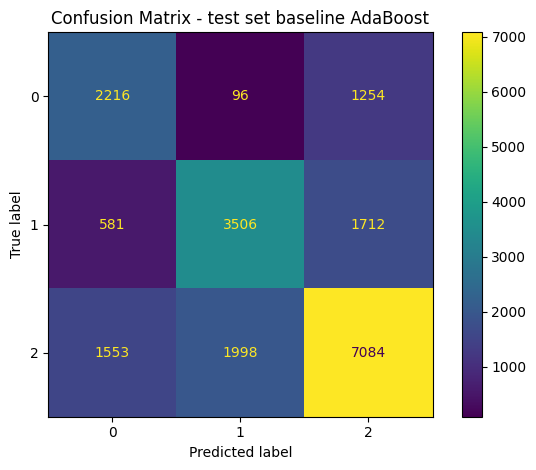

In [19]:
cm = confusion_matrix(y_test, y_pred_base)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline AdaBoost")
plt.tight_layout()
plt.show()

In [20]:
# with mlflow.start_run(run_name="AdaBoost_baseline"):
#     mlflow.log_metrics(cv_base_metrics)
#     mlflow.log_metrics(test_metrics_base)

In [ ]:
params_distribution = {
    "ada_clf__n_estimators": [50, 100, 200, 400, 600],
    "ada_clf__learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5, 1.0],
    "ada_clf__estimator": [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),],
    "ada_clf__algorithm": ["SAMME"]
    }

random_search = RandomizedSearchCV(
    estimator=ada_clf,
    param_distributions=params_distribution,
    n_iter=30,
    scoring="f1_macro",
    n_jobs=6,
    cv=cv,
    random_state=42,
    verbose=1,
    return_train_score=False,
)

random_search.fit(X_train, y_train)

best_ada = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: Fut

In [ ]:
best_params

In [ ]:
cv_result_tuned = cross_validate(
    best_ada,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=6,
    verbose=1,
    return_train_score=False,
)

cv_tuned_metrics_mean = {
    f"cv_{metrics}_mean_tuned": float(cv_result_tuned[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_tuned_metris_std = {
    f"cv_{metrics}_std_tuned": float(cv_result_tuned[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}
cv_metrics_tuned = {**cv_tuned_metrics_mean, **cv_tuned_metris_std}

pd.DataFrame([cv_metrics_tuned])

In [ ]:
best_ada.fit(X_train, y_train)

y_pred_tuned = best_ada.predict(X_test)

test_metrics_tuned = {
    "test_accuracy": accuracy_score(y_test, y_pred_tuned),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_tuned),
    "test_f1_macro": f1_score(y_test, y_pred_tuned, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_tuned, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_tuned, average="macro"),
}
pd.DataFrame([test_metrics_tuned])

In [ ]:
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.title("Confusion Matrix - test set AdaBoost tuned")
plt.tight_layout()
plt.show()

In [ ]:
with mlflow.start_run(run_name="AdaBoost_tuned")
mlflow.log_metrics(cv_metrics_tuned)
mlflow.log_metrics(test_metrics_tuned)
mlflow.log_params(best_params)